# Part 1: Loading & Cleaning the data

### Import libraries

In [7]:
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

### Importing the data

The data is imported into a pandas dataframe.

In [8]:
df = pd.read_csv("../data/train.csv")

### Split Train/Test data

Before even viewing the data to avoid data snooping, it is split between a training and a testing set. 

A randomised 80%/20% split is used rather than stratified sampling because the dataset is large enough. According to Hands-On ML, if the dataset is large enough, the risk of introducing sampling bias is low (he mentions a set of 1,000 rows, whereas ours has 21,263 rows). 

The random number generator's seed is set at a fixed value to ensure that it always generates the same shuffle indices when re-running the code, ensuring reproducibility.

In [9]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

The train set should be 80% the size of the original, whereas the test set should 20%.

In [10]:
print("Train set size = {}, Test set size = {}".format(train_set.shape, test_set.shape))

Train set size = (17010, 82), Test set size = (4253, 82)


Now, only the *train_set* is used, while the *test_set* is set aside and forgotten about until the very end when the model's performance will be evaluated.

# Part 2: Analysis & Visualising the data

### Data overview

We make a copy of the training set (called exploration set) used for exploration purposes without introducing the risk of unvoluntarily harming the original training set.

In [11]:
exploration_set = train_set.copy()

Visualising the data table.

In [12]:
exploration_set.head(5)

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
16546,2,77.143500,53.722300,71.372307,51.848347,0.619298,0.497747,58.55300,32.438300,29.276500,...,4.000000,4.000000,4.000000,0.693147,0.325083,0,3.200000,0.000000,0.000000,5.0
5970,4,104.365600,71.922350,72.746865,43.369558,1.129463,1.221243,184.59060,26.332050,70.392496,...,2.000000,2.000000,2.000000,1.386294,1.207974,0,0.800000,0.000000,0.000000,97.0
7542,5,74.231650,51.256952,60.515221,34.941384,1.453747,1.327852,121.32760,20.724892,39.445875,...,2.076923,2.168944,2.063362,1.594167,1.229147,1,1.064615,0.400000,0.266469,62.1
2157,7,88.309607,48.586910,69.138309,33.542945,1.740703,1.724444,191.20060,11.938538,57.329551,...,2.138462,2.479397,2.104979,1.908037,1.479833,2,1.030769,0.728431,0.451559,60.0
18265,5,69.321369,72.150027,56.104529,55.643005,1.434383,1.302362,124.90825,31.227062,40.715396,...,3.575000,3.437544,3.381939,1.567056,1.488545,3,0.950000,1.019804,1.115516,4.0


Number of columns and rows in the dataset.

In [13]:
exploration_set.shape

(17010, 82)

Visualise information about each attribute, ensuring that there are not missing features (the number of **non-null count** should be equal to the number of rows) and whether attributes are numerical or not.

In [14]:
exploration_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17010 entries, 16546 to 15795
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               17010 non-null  int64  
 1   mean_atomic_mass                 17010 non-null  float64
 2   wtd_mean_atomic_mass             17010 non-null  float64
 3   gmean_atomic_mass                17010 non-null  float64
 4   wtd_gmean_atomic_mass            17010 non-null  float64
 5   entropy_atomic_mass              17010 non-null  float64
 6   wtd_entropy_atomic_mass          17010 non-null  float64
 7   range_atomic_mass                17010 non-null  float64
 8   wtd_range_atomic_mass            17010 non-null  float64
 9   std_atomic_mass                  17010 non-null  float64
 10  wtd_std_atomic_mass              17010 non-null  float64
 11  mean_fie                         17010 non-null  float64
 12  wtd_mean_fie  

Get a summary of numerical attributes (mean, min, max, standard deviation *std*, percentiles, ...).

In [15]:
exploration_set.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,...,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000
mean,4.117578,87.552301,73.014222,71.230209,58.524760,1.165758,1.064644,115.807500,33.268249,44.469461,...,3.152422,3.055893,3.054759,1.296302,1.054448,2.043621,1.480827,0.840799,0.676599,34.533301
std,1.440061,29.605104,33.431761,30.958597,36.607064,0.364937,0.401305,54.777673,26.997029,20.087431,...,1.190254,1.044198,1.173249,0.392751,0.380438,1.240678,0.977362,0.484323,0.455844,34.334673
min,1.000000,6.941000,6.941000,5.685033,3.193745,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.752000,52.183279,58.049320,35.271739,0.969858,0.776228,78.334500,16.841153,32.890369,...,2.118507,2.279705,2.092099,1.060857,0.779489,1.000000,0.920598,0.451754,0.308499,5.400000
50%,4.000000,84.964254,60.839112,66.361592,39.898482,1.199541,1.147161,122.906070,26.648959,45.135200,...,2.609091,2.615321,2.430426,1.368922,1.168096,2.000000,1.062500,0.800000,0.500000,20.000000
75%,5.000000,100.351275,86.124629,77.866234,73.069919,1.444537,1.360653,155.006000,38.421775,59.663892,...,4.029963,3.727919,3.919136,1.589027,1.332245,3.000000,1.912000,1.200000,1.021057,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


Plot each numerical attribute in a small histogram to more easily visualise it and make a quick analysis.

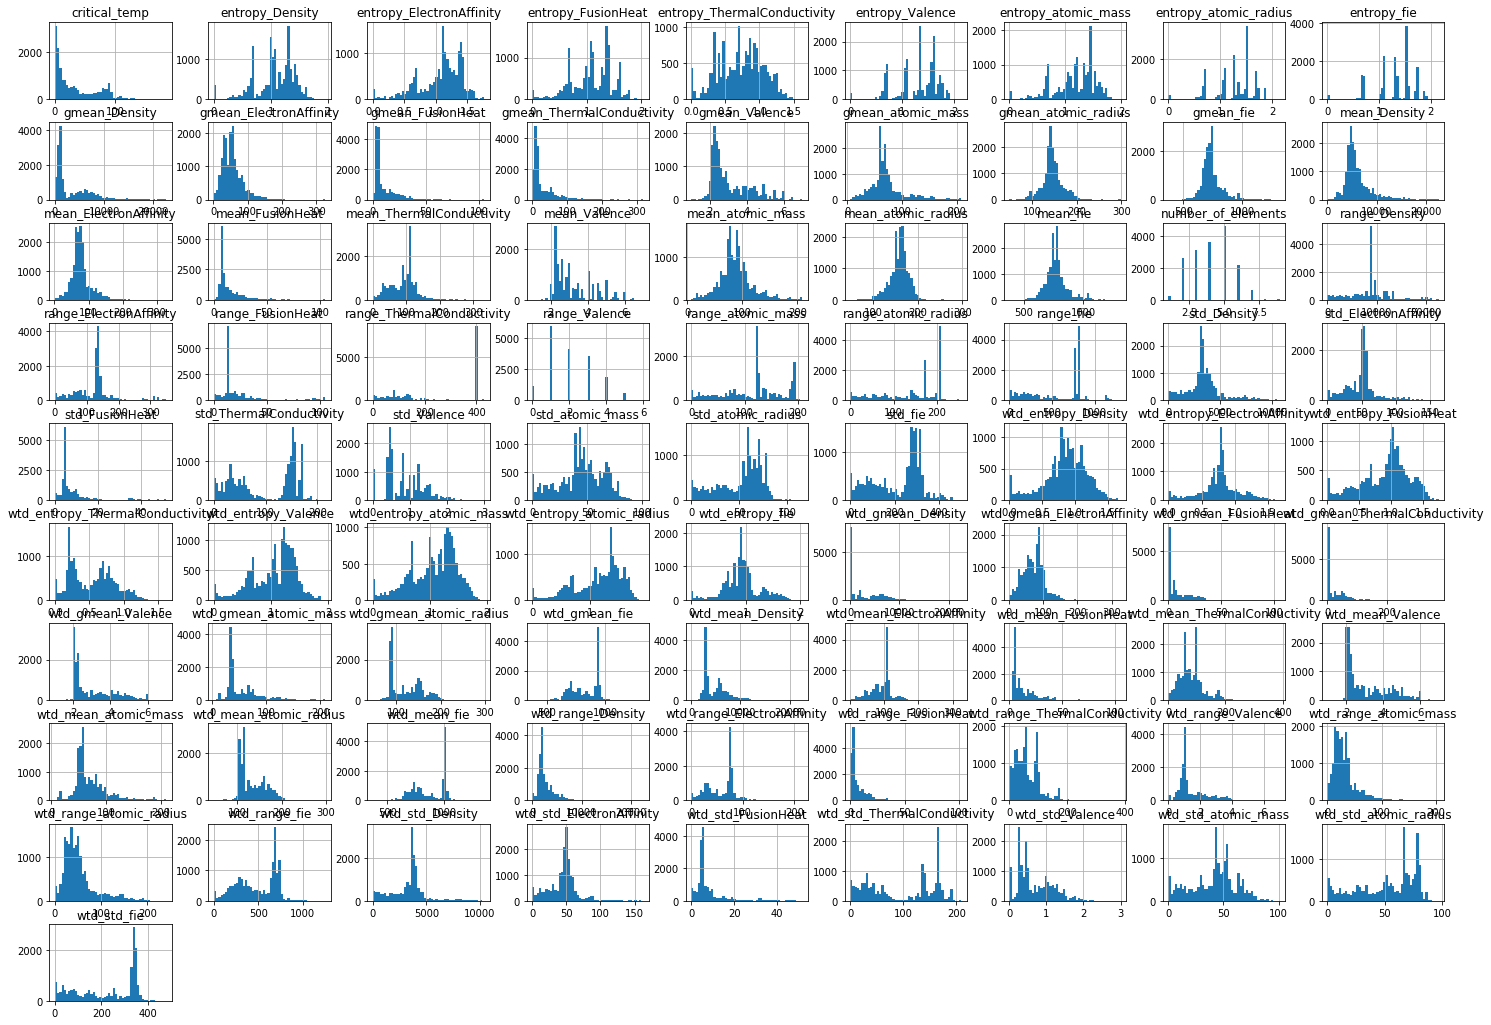

In [16]:
%matplotlib inline
exploration_set.hist(bins=50, figsize=(25,18))
plt.show()

--> This reveals 2 characteristics about the data:
* some attributes  are head-heavy and some are tail-heavy: ideally, want bell-shaped distributions to make it easier for the regression model to detect patterns. Will require attribute transformation later to achieve this.
* these features don't have the same scale, will require feature scaligng later to achieve this.

### Visualising the data to gain insights

The correlation matrix is computed to identify the correlation between each feature and the target value. The closer it is to 1, the stronger the correlation is, and vice versa when the correlation is close to -1. A correlation of 0 can be translated as a lack of linear correlatio

In [17]:
correlation_matrix = exploration_set.corr()
print("10 features with the strongest correlation with 'critical_temp':")
display(correlation_matrix["critical_temp"].sort_values(ascending=False).head(11))
print("\n10 features with the weakest correlation with 'critical_temp':")
display(correlation_matrix["critical_temp"].sort_values(ascending=True).head(10))

10 features with the strongest correlation with 'critical_temp':


critical_temp                  1.000000
wtd_std_ThermalConductivity    0.720134
range_ThermalConductivity      0.686189
std_ThermalConductivity        0.652264
range_atomic_radius            0.652252
wtd_entropy_atomic_mass        0.626036
wtd_entropy_atomic_radius      0.603819
number_of_elements             0.601491
range_fie                      0.600777
entropy_Valence                0.598086
wtd_std_atomic_radius          0.595144
Name: critical_temp, dtype: float64


10 features with the weakest correlation with 'critical_temp':


wtd_mean_Valence       -0.631542
wtd_gmean_Valence      -0.615452
mean_Valence           -0.598686
gmean_Valence          -0.572613
gmean_Density          -0.540816
wtd_gmean_Density      -0.538003
wtd_range_Valence      -0.440938
wtd_gmean_FusionHeat   -0.432910
wtd_mean_Density       -0.432619
gmean_FusionHeat       -0.431195
Name: critical_temp, dtype: float64

The standard correlation coefficients of the target attribute and the 5 attributes with the highest correlation are plotted in a scatter plot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108aa1dd0>,
      dtype=object)

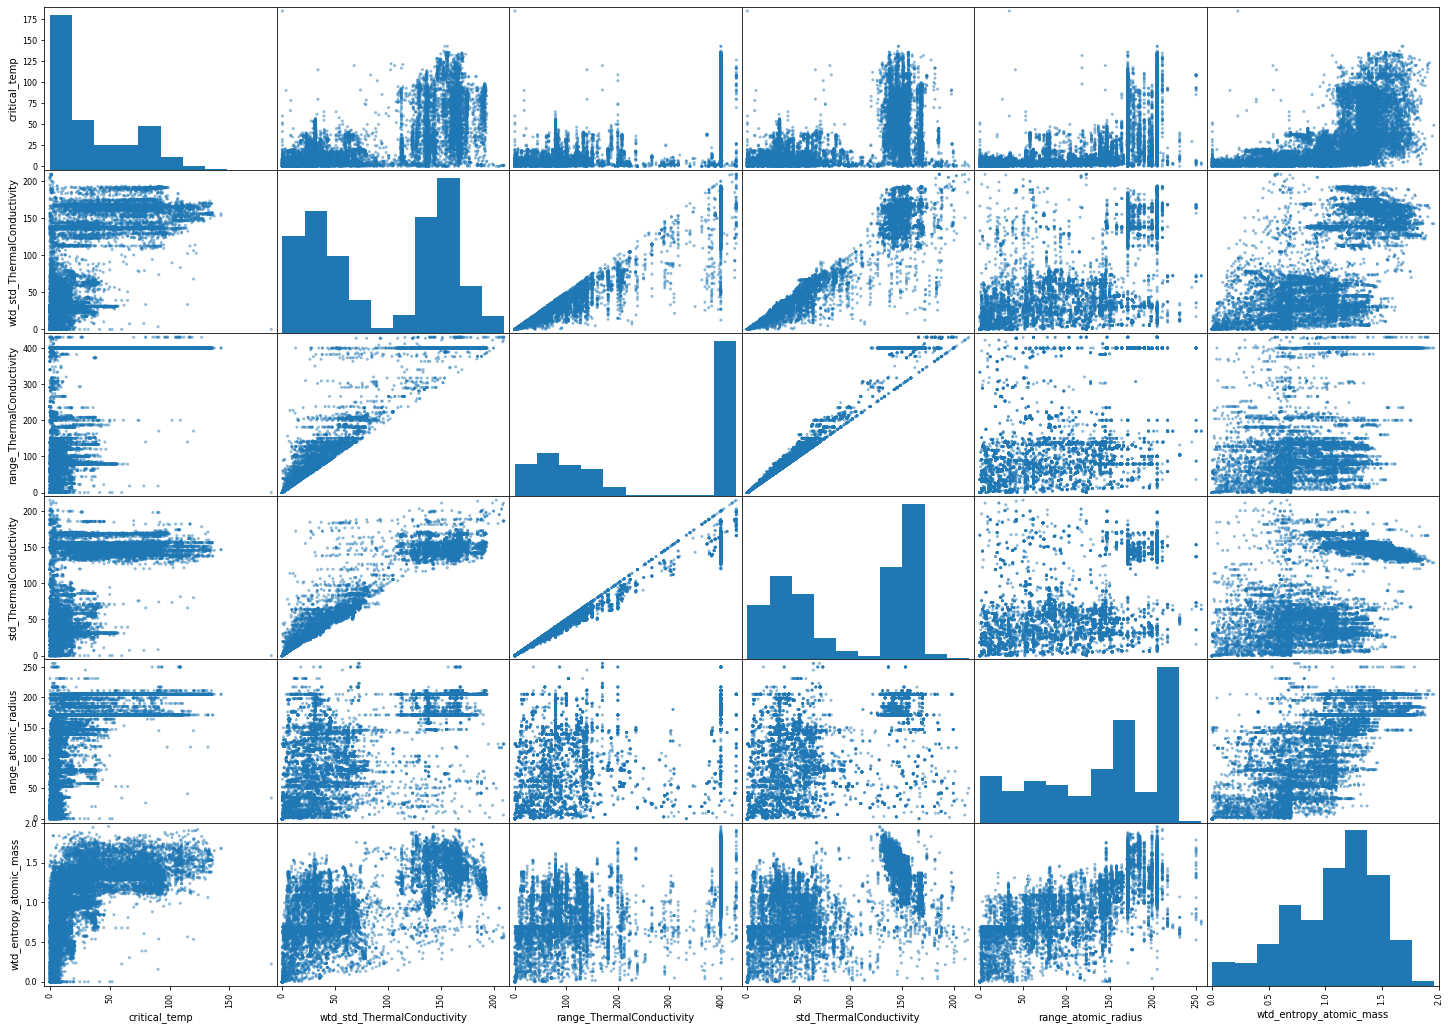

In [18]:
attributes = ["critical_temp", "wtd_std_ThermalConductivity", "range_ThermalConductivity", "std_ThermalConductivity", "range_atomic_radius", "wtd_entropy_atomic_mass"]
pd.plotting.scatter_matrix(exploration_set[attributes], figsize=(25, 18))
# save_fig("scatter_matrix_plot")

Because *wtd_std_ThermalConductivity* has the highest correlation with *critical_temp*, we can zoom in on the scatter plot between these two variables.

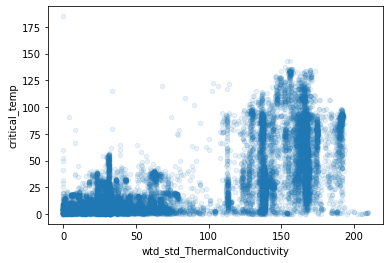

In [19]:
exploration_set.plot(kind="scatter", x="wtd_std_ThermalConductivity", y="critical_temp", alpha=0.1)

Observations: strong correlation

* upward trend (suggesting a correlation coefficient close to 1)

* Points not too dispersed

# Part 3: Preparing the inputs and choosing a suitable subset

Start by separating the predictors and the target values.

In [49]:
X = train_set.drop("critical_temp", axis=1)
y = train_set["critical_temp"].copy()

We can check that the split was correctly executed by ensuring that there are 82-1=81 columns in *X*, and only 1 column in *y*.

In [50]:
print("Predictors X size = {}, Target y size = {}".format(X.shape, y.shape))

Predictors X size = (17010, 81), Target y size = (17010,)


In terms of data cleaning there are no attributes missing values, no 0 or NaN values, and inferences on non-sensical values cannot be made due to lack of expert knowledge in the domain of supercondutors.

Additionally, there are no non-numerical attributes to deal with, so there is nothing to handle on this front.

# Part 4: Selecting and Training a regression model

The following errors are achieved by the paper:

* RMSE = 17.6K

* R^2 = 0.74

These results will be compared to our different models' results

### Functions

Function to briefly test the trained model with some data from the training set.

In [51]:
def quick_prediction_test(model, X, y):
    some_data = X.iloc[:5]
    some_labels = y.iloc[:5]
    print("Predictions: {}".format(model.predict(some_data)))
    print("Real value: {}".format(list(some_labels)))

Function to evaluate the RMSE and the R^2 score of the trained model.

In [52]:
def evaluate_model_error(model, target, prediction):
    mse = mean_squared_error(target, prediction)
    rmse = np.sqrt(mse)
    print("RMSE={}K".format(round(rmse, 2)))
    r_squared = r2_score(target, prediction)
    print("R^2={}%".format(round(r_squared, 2)))

Function to display cross-validation scores.

In [53]:
def display_detailed_scores(scores: list, metric_name: str) -> None:
    if metric_name == "RMSE":
        metric_unit = "K"
    elif metric_name == "R2":
        metric_unit = "%"
    else:
        metric_unit = ""
    print("\n{} scores achieved: {}".format(metric_name, scores))
    print("\nMean {}: {}{} (+/-{})".format(metric_name, round(scores.mean(), 2), metric_unit, round(scores.std(), 2)))

In [189]:
def plot_best_fit(y_actual, y_predicted, fig_name: str = "") -> None:
    m, b = np.polyfit(y_actual, y_predicted, 1)
    plt.scatter(y_actual, y_predicted, s=20, alpha=0.25, color="green")
    plt.plot(y_actual, (m * y_actual) + b, color='orange')
    plt.savefig("plot_{}.png".format(fig_name))
    plt.show()

Function to perform k-fold cross validation on a model.

In [124]:
def k_fold_cross_validation(model, X, y, folds=10):
    reg_model_mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=folds)
    reg_model_rmse_scores = np.sqrt(-reg_model_mse_scores)  # Computer negative score because sklearn's cross_val_score functione expects a utility function rather than a cost function, so it returns the reverse of the MSE.
    reg_model_r2_scores = cross_val_score(model, X, y, scoring="r2", cv=folds)
    print("{}-fold cross validation results:".format(folds))
    display_detailed_scores(reg_model_rmse_scores, metric_name="RMSE")
    display_detailed_scores(reg_model_r2_scores, metric_name="R2")

Function to save the model to a file.

In [55]:
def save_model(model, model_type):
    joblib.dump(model, "{}.pkl".format(model_type))

Function to load model.

In [56]:
def load_model(model_type):
    return joblib.load("{}.pkl".format(model_type))

Function to perform a grid search on a regression model.

In [128]:
def grid_search_algorithm(model, parameters, folds=5):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        cv=folds,  # perform 5-fold cross validation on each iteration.
        scoring="neg_mean_squared_error",
        return_train_score=True
    )

    grid_search.fit(X, y)
    return grid_search

## Linear Regression Models

Goal: quickly test different models without tweaking their parameters too much (to keep the default recommended parameters) in order to make a shortlist of 2 to 5 different model that work well with the data.

#### <u>General Linear Regression</u>

Train a linear regression model and quickly assess it.

Predictions: [ 2.81982681 72.83853211 62.60904699 70.41616711 24.86911432]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=17.61K
R^2=0.74%


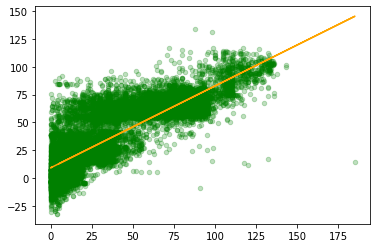

In [190]:
linear_regression = LinearRegression(fit_intercept=True, normalize=True)
linear_regression.fit(X, y)
quick_prediction_test(linear_regression, X, y)
y_prediction = linear_regression.predict(X)
evaluate_model_error(linear_regression, y, y_prediction)
plot_best_fit(y, y_prediction, "linear_reg")
save_model(linear_regression, "linear_reg")

Using the same model with 10-fold cross validation.

In [58]:
k_fold_cross_validation(linear_regression, X, y)

10-fold cross validation results:

RMSE scores achieved: [18.45082018 18.00777982 16.95175983 18.14080001 17.15519339 17.90118777
 17.86937038 17.5476235  17.29397962 17.50679636]

Mean RMSE: 17.68K (+/-0.45)

R2 scores achieved: [0.7144509  0.72942555 0.75706526 0.70860898 0.7321999  0.72314711
 0.74030987 0.7441437  0.74062472 0.75118776]

Mean R2: 0.73% (+/-0.01)


Quick evaluation of k-fold cross-validation:
* The mean score may be worse as it is an average of all folds (some of the folds may have split the data in ways that caused relevant data to be poorly split), but a new metric is revealed: the **standard deviation**
* However, running k-fold cross validation isn't always possible as it has the steep cost of multiplying execution times by the number of folds, which is not always possible. In the case of Linear Regression, this cost is fine, but using more data or more complex models such as neural networds or random forest generators would considerably increase the run time.
* **--> using 10-fold cross validation allows us to get a closer estimate of the model's performance, which is now: RMSE=17.68 +/- 0.45.** Getting this information would not have been possible if a single validation set (single fold) was being used to evaluate the training model.

#### <u>Linear Ridge Regression</u>

Predictions: [ 3.05086822 72.81782285 62.65345347 70.43998935 24.83306081]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=17.61K
R^2=0.74%


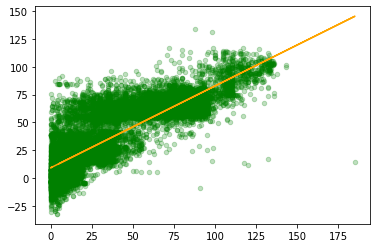

In [191]:
ridge_regression = Ridge(alpha=0.1, solver='svd', normalize=False)
ridge_regression.fit(X, y)
quick_prediction_test(ridge_regression, X, y)
evaluate_model_error(ridge_regression, y, ridge_regression.predict(X))
plot_best_fit(y, y_prediction, "ridge_reg")
save_model(ridge_regression, "ridge_reg")

In [62]:
k_fold_cross_validation(ridge_regression, X, y)

10-fold cross validation results:

RMSE scores achieved: [18.454123   18.0116879  16.95022017 18.13807084 17.15759591 17.90727455
 17.87156861 17.54961366 17.29295859 17.49025381]

Mean RMSE: 17.68K (+/-0.45)

R2 scores achieved: [0.71434866 0.72930809 0.75710939 0.70869665 0.73212488 0.72295881
 0.74024598 0.74408566 0.74065534 0.75165775]

Mean R2: 0.73% (+/-0.01)


Observations:
* normalising increases RMSE from 17.61 (R2=0.74%) to 19.2 (R2=0.69%)

Applying grid search algorithm to the **Ridge Regression** model to explore combinations of hyperparameters to find the best hyperparameters for a model, since doing so manually is a very time consuming task.

Manually tweaking individual hyperparameters on the Ridge Regression model to see which have an impact on the solution and test these in the grid search algorithm. Based on the manual trials the following have an impact:
* alpha: 0.1 to 10, under 0.1 no effect, above 10 error increases too much
* tolerance: no effect on error
* normalize: affects error (T or F)
* solver: some affect the error - can try all of them {‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’}

In [145]:
parameters = {
    "alpha": [0.1, 1, 10],
    "normalize": [True, False],
    "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
}
ridge_reg_gs_results = grid_search_algorithm(Ridge(), parameters, folds=5)
ridge_reg_gs_results_df = pd.DataFrame(ridge_reg_gs_results.cv_results_)
ridge_reg_gs_results_df.to_csv("ridge_reg_grid_search_results.csv")

Top 5 hyperparameters found for Ridge Regression.

In [146]:
ridge_reg_gs_results_df.sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_normalize,param_solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,0.055514,0.005327,0.003876,0.003664,0.1,False,svd,"{'alpha': 0.1, 'normalize': False, 'solver': '...",-332.907142,-308.237826,...,-313.328095,10.422245,1,-305.105524,-311.170516,-311.192388,-309.713305,-312.329931,-309.902333,2.538144
7,0.015129,0.001660,0.001744,0.000095,0.1,False,auto,"{'alpha': 0.1, 'normalize': False, 'solver': '...",-332.907142,-308.237826,...,-313.328095,10.422245,2,-305.105524,-311.170516,-311.192388,-309.713305,-312.329931,-309.902333,2.538144
9,0.013939,0.000167,0.001690,0.000100,0.1,False,cholesky,"{'alpha': 0.1, 'normalize': False, 'solver': '...",-332.907142,-308.237826,...,-313.328095,10.422245,2,-305.105524,-311.170516,-311.192388,-309.713305,-312.329931,-309.902333,2.538144
22,0.050603,0.001239,0.001907,0.000074,1,False,svd,"{'alpha': 1, 'normalize': False, 'solver': 'svd'}",-333.370608,-308.432566,...,-313.571516,10.654301,4,-305.406716,-311.582004,-311.494721,-310.042635,-312.855477,-310.276311,2.592644
23,0.016772,0.000522,0.001837,0.000041,1,False,cholesky,"{'alpha': 1, 'normalize': False, 'solver': 'ch...",-333.370608,-308.432566,...,-313.571516,10.654301,5,-305.406716,-311.582004,-311.494721,-310.042635,-312.855477,-310.276311,2.592644


Best model found by grid search algorithm for Ridge Regression.

In [147]:
final_ridge_reg_model = ridge_reg_gs_results.best_estimator_
print(final_ridge_reg_model)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='svd', tol=0.001)


Optimal parameters found by the grid search:
* alpha = 0.1
* normalize = False
* solver = svd

#### <u>Linear Lasso Regression</u>

Alpha corresponds to the constant that multiplies the L1 term.

Based on the manual trials the following hyperparameters have an impact on the error:
* alpha: 0.01 to 10, under 0.1 no effect, above 10 error increases too much. If alpha = 0, then it is just a simple least square.
* tolerance: precision
* positive: T/F to force coefficients to be positive
* selection: "cyclic" or "random" to decide which coefficient to update (either randomly or sequentially) - often leads to significantly faster convergence especially when tol is higher than 1e-4

/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2657342.9865852958, tolerance: 2005139.5458047707
  positive)


Predictions: [ 5.15081284 71.9851063  62.39995914 71.42022415 23.84552758]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=17.67K
R^2=0.74%


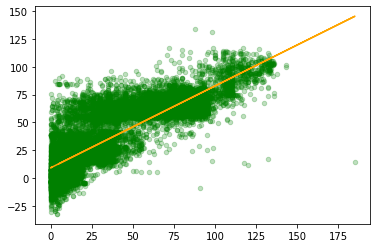

In [192]:
lasso_regression = Lasso(alpha=0.0001, tol=0.1, selection="random", positive=False, max_iter=1000)
lasso_regression.fit(X, y)
quick_prediction_test(lasso_regression, X, y)
evaluate_model_error(lasso_regression, y, lasso_regression.predict(X))
plot_best_fit(y, y_prediction, "lasso_reg")
save_model(lasso_regression, "lasso_reg")

In [123]:
k_fold_cross_validation(lasso_regression, X, y, folds=5)

/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2091221.6882751205, tolerance: 1598354.4216121833
  positive)
/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2133710.556731514, tolerance: 1611585.039503153
  positive)
/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2131357.00436136, tolerance: 1620634.2

10-fold cross validation results:

RMSE scores achieved: [18.3039669  17.58349469 17.6415865  17.80206975 17.42266478]

Mean RMSE: 17.75K (+/-0.3)

R2 scores achieved: [0.71983609 0.73250865 0.72432013 0.73953046 0.74564344]

Mean R2: 0.73% (+/-0.01)


/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2143178.9063453716, tolerance: 1599057.084228201
  positive)


In [154]:
parameters = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 0, 1, 10],
    "tol": [0.01, 0.1, 1],
    "positive": [True, False],
    "selection": ["cyclic", "random"]
}
lasso_reg_gs_results = grid_search_algorithm(Lasso(), parameters, folds=5)
lasso_reg_gs_results_df = pd.DataFrame(lasso_reg_gs_results.cv_results_)
lasso_reg_gs_results_df.to_csv("lasso_reg_grid_search_results.csv")

/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776046.7022137488, tolerance: 159835.44216121832
  positive)
/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3008588.155544913, tolerance: 159905.7084228201
  positive)
/Users/ajaamour/Environments/ML-Predicting-Superconductivity-Critical-Temperature-CS5014/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3008588.155544913, tolerance: 1599057.0

In [155]:
lasso_reg_gs_results_df.sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_positive,param_selection,param_tol,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
57,2.186520,0.098646,0.001991,0.000064,0,False,random,0.01,"{'alpha': 0, 'positive': False, 'selection': '...",-335.213710,...,-315.199602,10.875475,1,-307.379477,-313.713979,-313.146255,-311.576925,-314.865007,-312.136328,2.603658
21,2.263261,0.237479,0.001928,0.000131,0.001,False,random,0.01,"{'alpha': 0.001, 'positive': False, 'selection...",-335.048834,...,-315.280529,10.801342,2,-307.388504,-313.760104,-313.349128,-311.669792,-315.004651,-312.234436,2.647496
58,2.012100,0.068745,0.001951,0.000022,0,False,random,0.1,"{'alpha': 0, 'positive': False, 'selection': '...",-335.124471,...,-315.283090,10.823677,3,-307.377310,-313.731423,-313.313764,-311.681170,-314.771293,-312.174992,2.596985
9,1.793353,0.023670,0.001713,0.000046,0.0001,False,random,0.01,"{'alpha': 0.0001, 'positive': False, 'selectio...",-335.090288,...,-315.285482,10.813833,4,-307.329139,-313.731330,-313.210768,-311.840285,-315.049740,-312.232253,2.658463
10,1.737905,0.031650,0.001759,0.000090,0.0001,False,random,0.1,"{'alpha': 0.0001, 'positive': False, 'selectio...",-335.116498,...,-315.301327,10.807837,5,-307.315721,-313.555096,-313.257358,-311.745608,-314.751736,-312.125104,2.588446


In [156]:
final_lasso_reg_model = lasso_reg_gs_results.best_estimator_
print(final_lasso_reg_model)

Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='random',
      tol=0.01, warm_start=False)


Optimal parameters found by the grid search (in 1000 max iterations):
* alpha = 0.0001
* positive = False
* selection = random
* tolerance = 0.1

#### <u>Linear ElasticNet Regression</u>

In [137]:
elastic_net_regression = ElasticNet(alpha=0.1, tol=0.1, max_iter=10000)
elastic_net_regression.fit(X, y)
quick_prediction_test(elastic_net_regression, X, y)
evaluate_model_error(elastic_net_regression, y, elastic_net_regression.predict(X))
save_model(elastic_net_regression, "elasticnet_reg")

Predictions: [13.55866976 74.78720335 62.40028956 73.96102192 25.18151669]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=18.05K
R^2=0.72%


In [138]:
k_fold_cross_validation(elastic_net_regression, X, y)

10-fold cross validation results:

RMSE scores achieved: [18.95469729 18.42520102 17.35305957 18.53772215 17.56982394 18.48098652
 18.28950445 17.89645305 17.65045684 17.75803613]

Mean RMSE: 18.09 (+/-0.49%)

R2 scores achieved: [0.69864171 0.71673631 0.74542711 0.69571816 0.71909833 0.70492279
 0.72795496 0.73387024 0.72982162 0.74399511]

Mean R2: 0.72 (+/-0.02%)


## Other regression models

### Decision Tree Regressor Model

Train a decision tree regression model and quickly assess it.

In [139]:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X, y)
quick_prediction_test(tree_regressor, X, y)
evaluate_model_error(tree_regressor, y, tree_regressor.predict(X))
save_model(tree_regressor, "tree_reg")

Predictions: [ 4.335      81.48571429 62.1        60.          4.        ]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=4.19K
R^2=0.99%


Using the same model with 10-fold cross validation.

In [140]:
k_fold_cross_validation(tree_regressor, X, y)

10-fold cross validation results:

RMSE scores achieved: [12.66943283 12.08070965 11.58535004 11.95999813 12.036902   12.44591014
 12.47084726 12.79768892 12.10047246 11.45348688]

Mean RMSE: 12.16 (+/-0.42%)

R2 scores achieved: [0.85022183 0.86483472 0.88869092 0.87001698 0.86858615 0.87295456
 0.86679057 0.86726446 0.87348528 0.89038581]

Mean R2: 0.87 (+/-0.01%)


### Multi Layer Perceptron Regressor Model

Train a MLP regression model and quickly assess it.

In [141]:
mlp_regressor = MLPRegressor()
mlp_regressor.fit(X, y)
quick_prediction_test(mlp_regressor, X, y)
evaluate_model_error(mlp_regressor, y, mlp_regressor.predict(X))
save_model(mlp_regressor, "mlp_reg")

Predictions: [-19.7222467   69.21685454  53.86200905  68.23495286 -11.88832155]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=28.36K
R^2=0.32%


Using the same model with 10-fold cross validation.

In [142]:
k_fold_cross_validation(mlp_regressor, X, y)

10-fold cross validation results:

RMSE scores achieved: [20.60057352 21.30979949 31.21091578 19.96401714 20.29656709 20.02637555
 21.73352299 26.55465196 18.28154795 18.83037964]

Mean RMSE: 21.88 (+/-3.78%)

R2 scores achieved: [0.3572221  0.68331262 0.7013567  0.68116663 0.70491305 0.6776974
 0.66039825 0.69009408 0.66561095 0.76433858]

Mean R2: 0.66 (+/-0.1%)


The error is slightly increasing when using k-fold cross compare to the  validation because

### SVM Regression Model

Train a SVR model and quickly assess it.

In [143]:
svr = SVR()
svr.fit(X, y)
quick_prediction_test(svr, X, y)
evaluate_model_error(svr, y, svr.predict(X))
save_model(svr, "svr")

Predictions: [ 2.28455384 62.1234282  47.53468531 57.31728926 40.9628067 ]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=24.88K
R^2=0.47%


Using the same model with 10-fold cross validation.

In [144]:
k_fold_cross_validation(svr, X, y)

10-fold cross validation results:

RMSE scores achieved: [25.83633068 25.45131535 25.13124311 24.21367268 23.96365426 24.60731121
 25.16086175 25.26942094 24.82303997 25.36971601]

Mean RMSE: 24.98 (+/-0.55%)

R2 scores achieved: [0.44009917 0.45951094 0.46606551 0.48085984 0.47745272 0.4768651
 0.48514141 0.46942097 0.46562192 0.47749603]

Mean R2: 0.47 (+/-0.01%)


### Random Forest Generator Regression Model

Train a Random Forest generator regression model and quickly assess it.

In [145]:
random_forest_generator_reg = RandomForestRegressor()
random_forest_generator_reg.fit(X, y)
quick_prediction_test(random_forest_generator_reg, X, y)
evaluate_model_error(random_forest_generator_reg, y, random_forest_generator_reg.predict(X))
save_model(random_forest_generator_reg, "random_forest_generator_reg")

Predictions: [ 4.39294667 82.50971762 58.899255   56.68        4.5151    ]
Real value: [5.0, 97.0, 62.1, 60.0, 4.0]
RMSE=5.1K
R^2=0.98%


Using the same model with 10-fold cross validation.

In [146]:
k_fold_cross_validation(random_forest_generator_reg, X, y)

10-fold cross validation results:

RMSE scores achieved: [10.46575407  9.81263732  8.90306386  9.94074944  9.15351298  9.39277707
 10.47851645  9.60896828  9.86694887  8.82650588]

Mean RMSE: 9.64 (+/-0.55%)

R2 scores achieved: [0.90776324 0.91996301 0.93170959 0.91474687 0.92364208 0.92453492
 0.91008985 0.92335257 0.91701276 0.93666689]

Mean R2: 0.92 (+/-0.01%)


# Part 5: Evaluating the performance of the model

In [157]:
X_test = test_set.drop("critical_temp", axis=1)
y_test = test_set["critical_temp"].copy()
evaluate_model_error(final_ridge_reg_model, y_test, final_ridge_reg_model.predict(X_test))

RMSE=17.38K
R^2=0.74%
